<a href="https://colab.research.google.com/github/merrymasti015/CAP2022GRP09/blob/main/PCAMZC321_Group09_FireEventDetection_HOG_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FireDetection SKLEARN-ML


 https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

### Histogram of Oriented Gradients(HOG)


Navneet Dalal and Bill Triggs introduced Histogram of Oriented Gradients(HOG) features in 2005. Histogram of Oriented Gradients (HOG) is a feature descriptor used in image processing, mainly for object detection. A feature descriptor is a representation of an image or an image patch that simplifies the image by extracting useful information from it.
The image is divided into small connected regions called cells, and for the pixels within each cell, a histogram of gradient directions is compiled. The descriptor is the concatenation of these histograms. The HOG descriptor focuses on the structure or the shape of an object. It is better than any edge descriptor as it uses magnitude as well as angle of the gradient to compute the features. 

The principle behind the histogram of oriented gradients descriptor is that local object appearance and shape within an image can be described by the distribution of intensity gradients or edge directions. The x and y derivatives of an image (Gradients) are useful because the magnitude of gradients is large around edges and corners due to abrupt change in intensity and we know that edges and corners pack in a lot more information about object shape than flat regions. So, the histograms of directions of gradients are used as features in this descriptor.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

ModelSaveFolder = "/content/gdrive/MyDrive/Fire_ImageDataSet/ModelSave"


Drive = "/content/gdrive/MyDrive/"
## Define root folder
RootFolder = Drive+"Fire_ImageDataSet/OutputFiles"

### Where to save models

ModelSaveFolder = Drive+"Fire_ImageDataSet/ModelSave"

print(ModelSaveFolder)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Fire_ImageDataSet/ModelSave


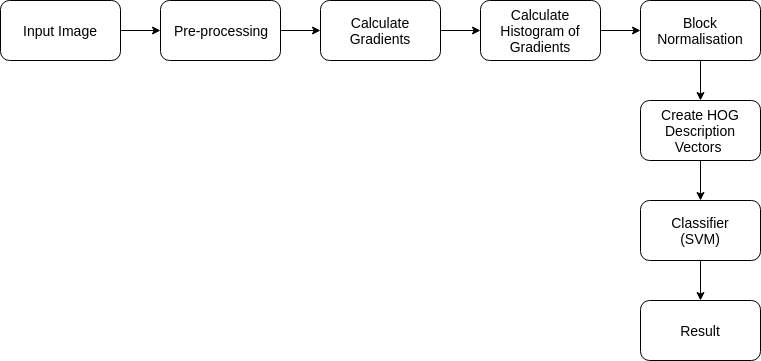

In [2]:
from IPython import display
display.Image(Drive+"HOG Workflow.jpg")

### Can we use deep Deep learning (like CNN) to learn HOG descriptors ??

##### 1. HOG is a hand-crafted feature that pools gradient responses over each cell block in an image. It is a representation.

##### 2 CNN is a multilayer architecture that learns the representations: It extracts the features (at each layer, get Gaussian filter responses and weigh them accordingly to the labels) itself. CNN is what makes all these hand-crafted features obsolete, as it defines the features space itself.

In [3]:
import os
import cv2
import itertools
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from skimage import feature ## Important for HOG
%matplotlib inline

In [4]:
#Import Random Forest Model
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [5]:
SKLearn_Model_Data = {}
Model_accuracy = {}

In [6]:
trainFrames  = pd.read_csv(RootFolder+"/Train_FramePathLocation.csv")

trainFrames.head()

,FrameFilename,FullPathName,GreyFullPathName,class
0,N_image_89.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
1,N_image_886.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
2,N_image_896.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
3,N_image_96.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
4,N_image_95.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral


In [7]:
trainFrames.shape

(1775, 4)

In [8]:
#Count Unique Values of occupation
trainFrames['class'].value_counts()

Neutral    900
Fire       875
Name: class, dtype: int64

In [9]:
#% of missing values in each column
def find_missing_values_func(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [10]:
#Call the find_missing_values_func(df)
columnsWiseMissingValue = find_missing_values_func(trainFrames) 
print(columnsWiseMissingValue)

Selected dataframe has 4 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [11]:
# Extract each frame  from trainFrames and store in a list - trainSetFramelist
trainSetFramelist = trainFrames["FullPathName"].tolist()
#print(trainSetFramelist)
print(len(trainSetFramelist))

1775


In [12]:
# Convert  nominal variable to numeric for calculating recall , precision , fp , tp , auc etc
trainFrames['class'] = trainFrames['class'].map({"Fire":0, "Neutral":1})

In [13]:
trainFrames.head()

,FrameFilename,FullPathName,GreyFullPathName,class
0,N_image_89.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
1,N_image_886.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
2,N_image_896.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
3,N_image_96.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
4,N_image_95.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1


In [14]:
No_Of_images = trainFrames.shape[0]
print(No_Of_images)

# Images are of various sizes, therefore, all the images needs to be downscaled to size 64*64
ROWS = 128
COLS = 256
CHANNELS = 3



1775


### Instead of using just the gradients of the images, using HOG features gives us the flexibility to accommodate small variations in orientation, size, etc of the objects. However using HOG features, we need to tune some parameters (number of orientation bins, grid of cells, cell sizes, the overlap between cells, block normalization, etc)

In [15]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


In [16]:
def Feature_Engg(file_path_list, train_test):
    
    No_Of_images = len(file_path_list)

    hog_feature = []
    labels      = []
    
    for i, image_file in enumerate(file_path_list):
        image = read_image(image_file)
        # get the HOG descriptor for the image
        #hog_desc = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
        #   cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
        
        hog_desc = feature.hog(image,                    #Input image
                               orientations=9,           # number of bins
                               pixels_per_cell=(8, 8),   # pixel per cell
                               cells_per_block=(2, 2),   # cells per block
                               transform_sqrt=True,      # the normalise parameter
                               block_norm='L2-Hys')      # normalizing across blocks
                               
                               # https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=hog - check for all param
        
        # update the data and labels
        hog_feature.append(hog_desc)
        
        #labels.append(train_test['class'][i])  # Either Neutral or Fire 
                  
    X =   np.array(hog_feature)  # convert to numpy array
    y  =  np.array(train_test['class']).reshape(len(train_test['class']),1)
 
    return X, y


In [17]:
X_train, y_train = Feature_Engg(trainSetFramelist,trainFrames)

   

In [18]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

X_train shape: (1775, 16740)
y_train shape: (1775, 1)


In [19]:
X_train

array([[0.30084649, 0.30084649, 0.09481396, ..., 0.        , 0.05680627,
        0.10883222],
       [0.31488516, 0.01955635, 0.00871309, ..., 0.01510496, 0.        ,
        0.        ],
       [0.24293078, 0.16140964, 0.04196509, ..., 0.        , 0.24561111,
        0.10258085],
       ...,
       [0.48101118, 0.031056  , 0.01020188, ..., 0.13282917, 0.06936967,
        0.        ],
       [0.45619715, 0.        , 0.        , ..., 0.02610267, 0.23768974,
        0.32349436],
       [0.18031241, 0.01027028, 0.00689403, ..., 0.00767621, 0.0082244 ,
        0.01441021]])

In [20]:
y_train 

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

### For Test frames 

In [21]:
# read testFrames csv
testFrames  = pd.read_csv(RootFolder+"/Test_FramePathLocation.csv")
testFrames.shape

(187, 4)

In [22]:
testFrames.head()

,FrameFilename,FullPathName,GreyFullPathName,class
0,TN_image_4.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
1,TN_image_40.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
2,TN_image_39.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
3,TN_image_99.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
4,TN_image_62.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral


In [23]:
#Call the find_missing_values_func(df)
columnsWiseMissingValue = find_missing_values_func(testFrames) 
print(columnsWiseMissingValue)

Selected dataframe has 4 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [24]:
#Count Unique Values of occupation
testFrames['class'].value_counts()

Fire       97
Neutral    90
Name: class, dtype: int64

In [25]:
# Extract each  from testFrames 
testSetFramelist = testFrames["FullPathName"].tolist()
print(len(testSetFramelist))

187


In [26]:
# Convert  nominal variable to numeric for calculating recall , precision , fp , tp , auc etc
testFrames['class'] = testFrames['class'].map({"Fire":0, "Neutral":1})

In [27]:
testFrames.head()

,FrameFilename,FullPathName,GreyFullPathName,class
0,TN_image_4.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
1,TN_image_40.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
2,TN_image_39.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
3,TN_image_99.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
4,TN_image_62.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1


In [28]:
X_test, y_test = Feature_Engg(testSetFramelist,testFrames)


In [29]:
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_test shape: (187, 16740)
y_test shape: (187, 1)


### SKLEARN ML

In [30]:
def plot_roc_curve(model, yTest, yPred):
    fpr, tpr, thresholds = roc_curve(yTest, yPred)
    roc_auc = auc(fpr, tpr)
    lw = 2
    #print('AUC area:', roc_auc)
    Model_accuracy = roc_auc_score(yTest,yPred)
    print('AUC roc_auc_score:', roc_auc_score(yTest,yPred))
    plt.plot([0,1],[0,1],'k--')
    #plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title(model)
    plt.show()
    return Model_accuracy,roc_auc

def getModelReport(modelName, yTest, yPredict) :
    accuracy = accuracy_score(yTest, yPredict)
    precision = precision_score(yTest, yPredict)
    recall = recall_score(yTest, yPredict)
    f1 = f1_score(yTest, yPredict)
    conf_matrix = confusion_matrix(yTest, yPredict)
    tn, fp, fn, tp = confusion_matrix(yTest, yPredict).ravel()
    precision_fire=tp/(tp+fp)                                                              # Precision = TruePositives / (TruePositives + FalsePositives)
    recall_fire= tp/(tp+fn)                                                                # Recall = TruePositives / (TruePositives + FalseNegatives)
    f1_fire= 2*precision_fire*recall_fire/(precision_fire*recall_fire)                     # (2 * Precision * Recall) / (Precision + Recall)
    precision_Neutral=tn/(tn+fn)                                                           # Precision = TruePositives / (TruePositives + FalsePositives)
    recall_Neutral= tn/(tn+fp)                                                             # Recall = TruePositives / (TruePositives + FalseNegatives)
    f1_Neutral= 2*precision_Neutral*recall_Neutral/(precision_Neutral*recall_Neutral)      # (2 * Precision * Recall) / (Precision + Recall)

    clf_report = classification_report(yTest, yPredict)

    print('\n\n*************************************************************************************')
    print('FOR {0}:'.format(modelName))
    print('ACCURACY:', accuracy)
    print('F1 SCORE:', f1)
    print('CONFUSION MATRIX: ')
    print(conf_matrix)
    print('CLASSIFICATION REPORT: ')
    print(clf_report)
    print('****************************************************************************************')
    return f1,precision_fire,recall_fire,f1_fire,precision_Neutral,recall_Neutral,f1_Neutral


In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1775, 16740)
(1775, 1)
(187, 16740)
(187, 1)


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = KNeighborsClassifier(n_neighbors=5)


*************************************************************************************
FOR KNN:
ACCURACY: 0.6898395721925134
F1 SCORE: 0.6506024096385543
CONFUSION MATRIX: 
[[75 22]
 [36 54]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.68      0.77      0.72        97
           1       0.71      0.60      0.65        90

    accuracy                           0.69       187
   macro avg       0.69      0.69      0.69       187
weigh

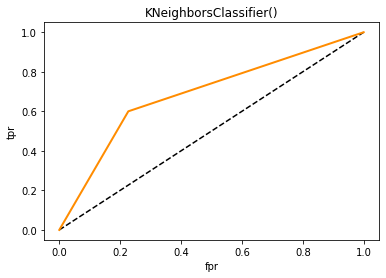

  Model  recall_fire  precision_fire  recall_neutral  precision_neutral  \
0   KNN          0.6        0.710526        0.773196           0.675676   

   f1_fire  f1_neutral  model_accuracy   roc_auc  
0      2.0         2.0        0.686598  0.686598  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = XGBClassifier(max_depth=2)


*************************************************************************************
FOR XGBoost:
ACCURACY: 0.8181818181818182
F1 SCORE: 0.8111111111111111
CONFUSION MATRIX: 
[[80 17]
 [17 73]]
CLASSIFICATION REPORT: 
              precisio

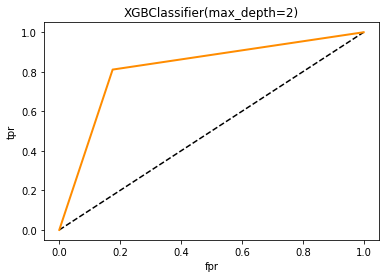

     Model  recall_fire  precision_fire  recall_neutral  precision_neutral  \
0  XGBoost     0.811111        0.811111        0.824742           0.824742   

   f1_fire  f1_neutral  model_accuracy   roc_auc  
0      2.0         2.0        0.817927  0.817927  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = RandomForestClassifier(n_estimators=100)


*************************************************************************************
FOR RandomForest:
ACCURACY: 0.7807486631016043
F1 SCORE: 0.768361581920904
CONFUSION MATRIX: 
[[78 19]
 [22 68]]
CLASSIFICATION REPORT:

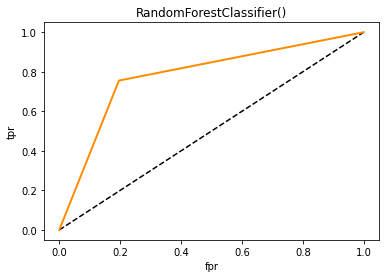

          Model  recall_fire  precision_fire  recall_neutral  \
0  RandomForest     0.755556        0.781609        0.804124   

   precision_neutral  f1_fire  f1_neutral  model_accuracy  roc_auc  
0               0.78      2.0         2.0         0.77984  0.77984  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LinearSVC(random_state=0, tol=1e-5)


*************************************************************************************
FOR SVM:
ACCURACY: 0.8181818181818182
F1 SCORE: 0.8131868131868132
CONFUSION MATRIX: 
[[79 18]
 [16 74]]
CLASSIFICATION REPORT: 
   

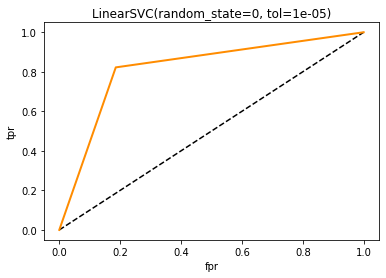

  Model  recall_fire  precision_fire  recall_neutral  precision_neutral  \
0   SVM     0.822222        0.804348        0.814433           0.831579   

   f1_fire  f1_neutral  model_accuracy   roc_auc  
0      2.0         2.0        0.818328  0.818328  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = DecisionTreeClassifier()


*************************************************************************************
FOR DecisionTree:
ACCURACY: 0.6417112299465241
F1 SCORE: 0.6528497409326425
CONFUSION MATRIX: 
[[57 40]
 [27 63]]
CLASSIFICATION REPORT: 
              preci

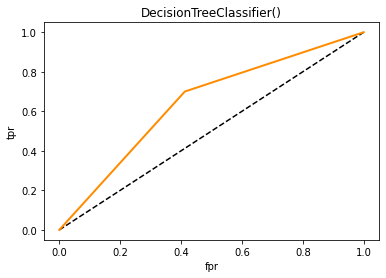

          Model  recall_fire  precision_fire  recall_neutral  \
0  DecisionTree          0.7         0.61165        0.587629   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.678571      2.0         2.0        0.643814  0.643814  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = GaussianNB()


*************************************************************************************
FOR Naive_Bayes:
ACCURACY: 0.786096256684492
F1 SCORE: 0.7802197802197802
CONFUSION MATRIX: 
[[76 21]
 [19 71]]
CLASSIFICATION REPORT: 
              pre

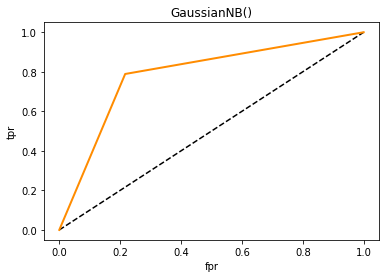

         Model  recall_fire  precision_fire  recall_neutral  \
0  Naive_Bayes     0.788889        0.771739        0.783505   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0                0.8      2.0         2.0        0.786197  0.786197  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LogisticRegressionCV()


*************************************************************************************
FOR LogisticRegressionCV:
ACCURACY: 0.8074866310160428
F1 SCORE: 0.8000000000000002
CONFUSION MATRIX: 
[[79 18]
 [18 72]]
CLASSIFICATION REPORT: 

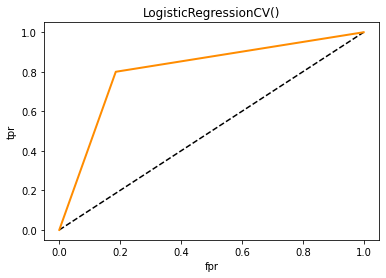

                  Model  recall_fire  precision_fire  recall_neutral  \
0  LogisticRegressionCV          0.8             0.8        0.814433   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.814433      2.0         2.0        0.807216  0.807216  
(1, 9)
(7, 9)


In [32]:
import pickle

def predict_classic_models(args,X_train, y_train, X_test,y_test):
    model_run_script = """from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

"""
    model_eval_data = pd.DataFrame()
    model_run_script = model_run_script+'model = '+ args[1] + '('+ args[2] +')'
    Vars = {}
    print(model_run_script)
    exec(model_run_script, Vars)
    model = Vars['model']
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    f1,precision_fire,recall_fire,f1_fire,precision_Neutral,recall_Neutral,f1_Neutral = getModelReport(args[0], y_test, y_predict)
    # roc curve
    model_eval_data['Model'] = [args[0]]
    model_eval_data['recall_fire'] = [recall_fire]
    model_eval_data['precision_fire'] = [precision_fire]
    model_eval_data['recall_neutral'] = [recall_Neutral]
    model_eval_data['precision_neutral'] = [precision_Neutral]
    model_eval_data['f1_fire'] = [f1_fire]
    model_eval_data['f1_neutral'] = [f1_Neutral]
    file_name = ModelSaveFolder+'/'+args[0]+'_HOB.h5'
    pickle.dump(model, open(file_name,'wb'))

    Model_acc,roc_auc=plot_roc_curve(model,y_test,y_predict)

    model_eval_data['model_accuracy'] = [Model_acc]
    model_eval_data['roc_auc'] = [roc_auc]
    print(model_eval_data)
    print(model_eval_data.shape)
    return model_eval_data

#arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV',''],["GridSearchCV","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]
arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV','']]

eval_data_for_all_models = pd.DataFrame()
current_df = pd.DataFrame()


for model_args in arr_models:
    model_eval_data=predict_classic_models(model_args,X_train, y_train, X_test,y_test)
    current_df=pd.concat([model_eval_data,current_df])

eval_data_for_all_models = pd.concat([eval_data_for_all_models , current_df])
print(eval_data_for_all_models.shape)
eval_data_for_all_models.to_csv(RootFolder+'/step0_frameFile_comparison_model_eval_HOB.csv',header=True, index=False)

## PCA - This is a technique that comes from the field of linear algebra and can be used as a data preparation technique to create a projection of a dataset prior to fitting a model.- Unsupervised
https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from xgboost.sklearn import XGBRegressor

In [34]:
pca=RandomizedPCA(n_components = 1500, whiten=True).fit(X_train)
x_train_pca=pca.transform(X_train)


150.54001884121527 0.9830746605507159


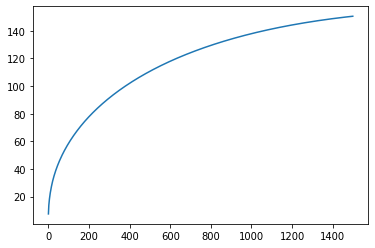

In [35]:
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
print(np.sum(explained_variance), np.sum(explained_variance_ratio))

#### Dimensional reduction and fetures selection
### scikit-learn choose the minimum number of principal components such that 98% of the variance is retained.

In [36]:
pca=RandomizedPCA(n_components=1500, whiten=True).fit(X_train)
x_train_pca=pca.transform(X_train)
x_test_pca=pca.transform(X_test)



In [37]:
print(x_train_pca.shape)
print(x_test_pca.shape)

(1775, 1500)
(187, 1500)


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = XGBClassifier(max_depth=2)


*************************************************************************************
FOR XGBoost_PCA:
ACCURACY: 0.8021390374331551
F1 SCORE: 0.7955801104972374
CONFUSION MATRIX: 
[[78 19]
 [18 72]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        97
           1       0.79      0.80      0.80        90

    accuracy                           0.80       187
   macro avg       0.80      0.80      0.80       187
weight

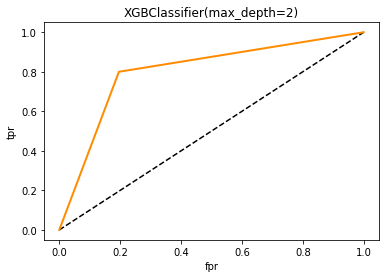

         Model  recall_fire  precision_fire  recall_neutral  \
0  XGBoost_PCA          0.8        0.791209        0.804124   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0             0.8125      2.0         2.0        0.802062  0.802062  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = RandomForestClassifier(n_estimators=100)


*************************************************************************************
FOR RandomForest_PCA:
ACCURACY: 0.7433155080213903
F1 SCORE: 0.6756756756756757
CONFUSION MATRIX: 
[[89  8]
 [40 50]]
CLASSIFIC

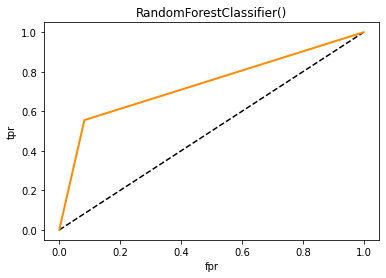

              Model  recall_fire  precision_fire  recall_neutral  \
0  RandomForest_PCA     0.555556        0.862069        0.917526   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.689922      2.0         2.0        0.736541  0.736541  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LinearSVC(random_state=0, tol=1e-5)


*************************************************************************************
FOR SVM_PCA:
ACCURACY: 0.7754010695187166
F1 SCORE: 0.7717391304347826
CONFUSION MATRIX: 
[[74 23]
 [19 71]]
CLASSIFICATIO

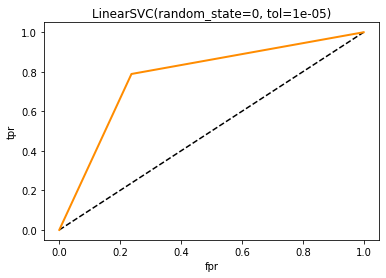

     Model  recall_fire  precision_fire  recall_neutral  precision_neutral  \
0  SVM_PCA     0.788889        0.755319        0.762887           0.795699   

   f1_fire  f1_neutral  model_accuracy   roc_auc  
0      2.0         2.0        0.775888  0.775888  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = DecisionTreeClassifier()


*************************************************************************************
FOR DecisionTree_PCA:
ACCURACY: 0.7379679144385026
F1 SCORE: 0.7262569832402235
CONFUSION MATRIX: 
[[73 24]
 [25 65]]
CLASSIFICATION REPORT: 
         

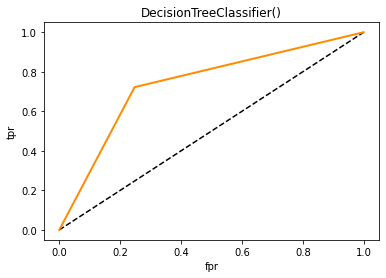

              Model  recall_fire  precision_fire  recall_neutral  \
0  DecisionTree_PCA     0.722222        0.730337        0.752577   

   precision_neutral  f1_fire  f1_neutral  model_accuracy  roc_auc  
0           0.744898      2.0         2.0          0.7374   0.7374  
(1, 9)
(11, 9)


In [38]:
#arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV',''],["GridSearchCV","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]
arr_models = [['XGBoost_PCA','XGBClassifier','max_depth=2'],['RandomForest_PCA','RandomForestClassifier','n_estimators=100'],['SVM_PCA','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree_PCA','DecisionTreeClassifier','']]

#eval_data_for_all_models = pd.DataFrame()
current_df = pd.DataFrame()


for model_args in arr_models:
    model_eval_data=predict_classic_models(model_args,x_train_pca, y_train, x_test_pca,y_test)
    current_df=pd.concat([model_eval_data,current_df])

eval_data_for_all_models = pd.concat([eval_data_for_all_models , current_df])
print(eval_data_for_all_models.shape)
eval_data_for_all_models.to_csv(RootFolder+'/step0_frameFile_comparison_model_eval_HOB.csv',header=True, index=False)


## Cross Validation (Grid Search) PCA data as data rows are less

####  Support Vector Machine (SVM) classifier with Histogram of Oriented Gradients (HOG) feature become one of the most popular techniques used for vehicle detection in recent years.

## Classify Using Radial Basis Function (RBF) - 

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LogisticRegressionCV()


*************************************************************************************
FOR LogisticRegressionCV_PCA:
ACCURACY: 0.8021390374331551
F1 SCORE: 0.7999999999999999
CONFUSION MATRIX: 
[[76 21]
 [16 74]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.83      0.78      0.80        97
           1       0.78      0.82      0.80        90

    accuracy                           0.80       187
   macro avg       0.80      0.80      0.80       1

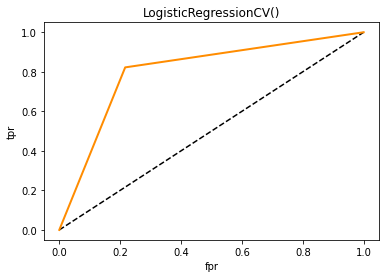

                      Model  recall_fire  precision_fire  recall_neutral  \
0  LogisticRegressionCV_PCA     0.822222        0.778947        0.783505   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.826087      2.0         2.0        0.802864  0.802864  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = GridSearchCV(estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]})


*************************************************************************************
FOR GridSearchCV_PCA

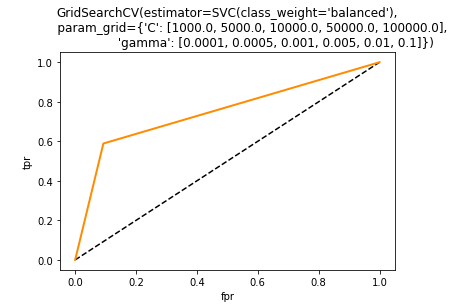

              Model  recall_fire  precision_fire  recall_neutral  \
0  GridSearchCV_PCA     0.588889        0.854839        0.907216   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0              0.704      2.0         2.0        0.748053  0.748053  
(1, 9)
(13, 9)


In [39]:
#arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV',''],["GridSearchCV","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]
arr_models = [['LogisticRegressionCV_PCA','LogisticRegressionCV',''],["GridSearchCV_PCA","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]

#eval_data_for_all_models = pd.DataFrame()
current_df = pd.DataFrame()


for model_args in arr_models:
    model_eval_data=predict_classic_models(model_args,x_train_pca, y_train, x_test_pca,y_test)
    current_df=pd.concat([model_eval_data,current_df])

eval_data_for_all_models = pd.concat([eval_data_for_all_models , current_df])
print(eval_data_for_all_models.shape)
eval_data_for_all_models.to_csv(RootFolder+'/step0_frameFile_comparison_model_eval_HOB.csv',header=True, index=False)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LinearSVC(random_state=0, tol=1e-5)


*************************************************************************************
FOR SVM_PCA:
ACCURACY: 0.7754010695187166
F1 SCORE: 0.7717391304347826
CONFUSION MATRIX: 
[[74 23]
 [19 71]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        97
           1       0.76      0.79      0.77        90

    accuracy                           0.78       187
   macro avg       0.78      0.78      0.78       187
w

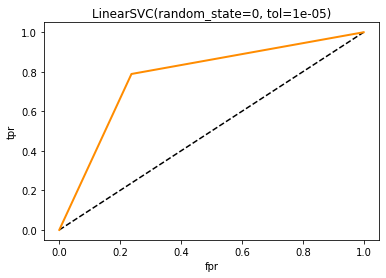

     Model  recall_fire  precision_fire  recall_neutral  precision_neutral  \
0  SVM_PCA     0.788889        0.755319        0.762887           0.795699   

   f1_fire  f1_neutral  model_accuracy   roc_auc  
0      2.0         2.0        0.775888  0.775888  
(1, 9)
(14, 9)


In [54]:
#arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV',''],["GridSearchCV","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]
arr_models = [['SVM_PCA','LinearSVC','random_state=0, tol=1e-5']]

#eval_data_for_all_models = pd.DataFrame()
current_df = pd.DataFrame()


for model_args in arr_models:
    model_eval_data=predict_classic_models(model_args,x_train_pca, y_train, x_test_pca,y_test)
    current_df=pd.concat([model_eval_data,current_df])

eval_data_for_all_models = pd.concat([eval_data_for_all_models , current_df])
print(eval_data_for_all_models.shape)
eval_data_for_all_models.to_csv(RootFolder+'/step0_frameFile_comparison_model_eval_HOB.csv',header=True, index=False)

## Saving the model as a pickel, retrieving the model and testing the model¶

In [55]:
#Testing the saved model
# load the saved model
with open(ModelSaveFolder+'/SVM_PCA_HOB.h5', 'rb') as file:
    loaded_model = pickle.load(file)

In [56]:
y1_predict_test_DecisionTree = loaded_model.predict(x_test_pca)

In [57]:
y1_predict_test_DecisionTree

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [58]:
# Numeric to semantic labels PCA_
label_dict = {1.0: 'No fire', 0.0: 'Fire'}
label_dict[y1_predict_test_DecisionTree[0]]


'No fire'

In [59]:
testFrames.head()

,FrameFilename,FullPathName,GreyFullPathName,class
0,TN_image_4.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
1,TN_image_40.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
2,TN_image_39.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
3,TN_image_99.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1
4,TN_image_62.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,1


In [60]:
testFrames["FullPathName"][4]

'/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Neutral/TN_image_62.jpg'

In [61]:
# for loop to read and store test frames
# creating two lists to store predicted and actual tags
predict = []
actual = []
model_match = []
indent_variable   = []
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

for i in range(len(testSetFramelist)):
    
    # appending the file name as indent
    indent_variable.append(testFrames['FullPathName'][i])
   


    # appending the actual class 
    actual_class  = label_dict[testFrames['class'][i]]
    actual.append(actual_class)
 
    
    #get the predicted class​  as fire and No fire
    predicted_class  = label_dict[y1_predict_test_DecisionTree[i]]
    # appending the predicted class
    predict.append(predicted_class)
    
    if (predicted_class == actual_class):
        model_match.append("Correct_Predtiction")
    else:
        model_match.append("Mis_classified")
        
    



In [62]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
EvalFinalOutput_gridsearch = pd.DataFrame(list(zip(indent_variable, actual ,predict , model_match )),
               columns =['FrameFileName', 'ActualClass' , 'PredictedClass', 'Is_correct'])

EvalFinalOutput_gridsearch.head()
## You can store in csv file

,FrameFileName,ActualClass,PredictedClass,Is_correct
0,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,No fire,No fire,Correct_Predtiction
1,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,No fire,No fire,Correct_Predtiction
2,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,No fire,No fire,Correct_Predtiction
3,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,No fire,No fire,Correct_Predtiction
4,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,No fire,No fire,Correct_Predtiction


## Misclassified Fire images

In [63]:
FireMisclassified = EvalFinalOutput_gridsearch[(EvalFinalOutput_gridsearch['ActualClass'] == 'Fire') & (EvalFinalOutput_gridsearch['Is_correct'] == 'Mis_classified')]

FireMisclassified.shape

(23, 4)

In [64]:
listOfImageNames = FireMisclassified["FrameFileName"].tolist()

print(listOfImageNames)

['/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_24.jpg', '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_85.jpg', '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_4.jpg', '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_76.jpg', '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_89.jpg', '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_44.jpg', '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_64.jpg', '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_77.jpg', '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_47.jpg', '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Test/Fire/TF_image_18.jpg', '/content/gdrive/MyDrive/Fire_ImageDataS

In [65]:
from keras.preprocessing import image
from pathlib import Path
import matplotlib.pyplot as plt

In [66]:
# Display images side by side.
def display_images(file_path_list,title):

    #intro_files=file_path_list
    fig=plt.figure(figsize=(10,9))
    plt.title(title)
    plt.axis('off')

    for i in range(len(file_path_list)):
        if (i== 12):
            break
        ax=fig.add_subplot(3,4, i+1)
        temp = Path(file_path_list[i]).stem
        plt.title(temp, y=-0.3)
        ax.imshow(image.load_img(file_path_list[i], target_size=(300,300)))
    plt.show()


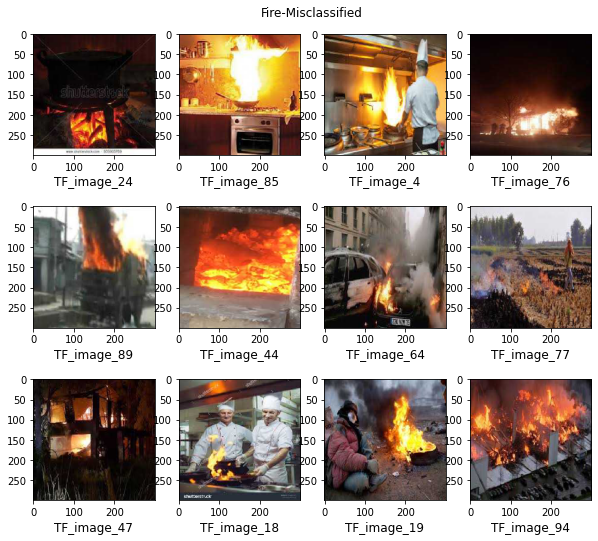

In [67]:
display_images(listOfImageNames, 'Fire-Misclassified')

In [68]:
Fireclassified = EvalFinalOutput_gridsearch[(EvalFinalOutput_gridsearch['ActualClass'] == 'Fire') & (EvalFinalOutput_gridsearch['Is_correct'] == 'Correct_Predtiction')]

Fireclassified.shape

(74, 4)

In [69]:
listOfImageNames = Fireclassified["FrameFileName"].tolist()

print(len(listOfImageNames))

74


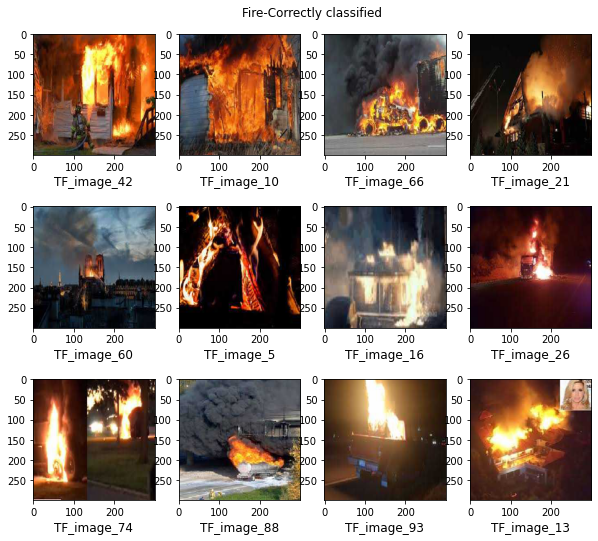

In [70]:
display_images(listOfImageNames, 'Fire-Correctly classified')

### Do the same for no fire cases 